# Test biaslyze with the toxic comments dataset

Data source: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import sys
sys.path.append('/home/tobias/Repositories/biaslyze/')

In [74]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

## Load and prepare data

In [7]:
df = pd.read_csv("../data/jigsaw-toxic-comment-classification/train.csv"); df.head()

id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0

In [8]:
# make the classification problem binary
df["target"] = df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].sum(axis=1) > 0

## Train a BoW-model

In [9]:
clf = make_pipeline(TfidfVectorizer(min_df=10, max_features=10000, stop_words="english"), LogisticRegression())

In [10]:
clf.fit(df.comment_text, df.target)

/home/tobias/.cache/pypoetry/virtualenvs/biaslyze-OjqpgMw8-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=10000, min_df=10,
                                 stop_words='english')),
                ('logisticregression', LogisticRegression())])

In [11]:
train_pred = clf.predict(df.comment_text)
print(accuracy_score(df.target, train_pred))

0.9605755431751384


### probe the model a bit to see if we got an obvious problem

In [12]:
test_text = "Jews and muslims are great friends!"

print(clf.predict_proba([test_text]))

[[0.91499231 0.08500769]]


In [13]:
test_text = "That woman is great!"

print(clf.predict_proba([test_text]))

[[0.9287197 0.0712803]]


In [14]:
test_text = "That man is great!"

print(clf.predict_proba([test_text]))

[[0.92822178 0.07177822]]


In [15]:
test_text = "That muslim woman is great deed for islam!"

print(clf.predict_proba([test_text]))

[[0.79439839 0.20560161]]


In [16]:
test_text = "My mother is a jew."

print(clf.predict_proba([test_text]))

[[0.27918978 0.72081022]]


### Look at the logistc regression coefficients

In [17]:
coef = clf.named_steps.get("logisticregression").coef_

In [18]:
vocab = clf.named_steps.get("tfidfvectorizer").vocabulary_

In [19]:
vocab_coef_dict = {token: coef[0][idx] for token, idx in vocab.items()}

In [20]:
dict(sorted(vocab_coef_dict.items(), key=lambda v: -v[1]))

{'fuck': 17.80540365099103,
 'fucking': 14.635332881375062,
 'shit': 12.776545770068545,
 'idiot': 12.575476050602957,
 'stupid': 11.43395617454563,
 'ass': 10.928078279290391,
 'bullshit': 10.013142053233421,
 'asshole': 9.934778096130305,
 'bitch': 9.418717740305228,
 'suck': 9.310144753582346,
 'crap': 8.497103499739891,
 'dick': 7.980834777990305,
 'moron': 7.977000019330612,
 'cunt': 7.970742269355696,
 'faggot': 7.927285379438609,
 'idiots': 7.5557181070319865,
 'sucks': 7.55191693535309,
 'penis': 7.131695708016156,
 'bastard': 6.814701495629582,
 'pathetic': 6.797036943528691,
 'hell': 6.54890040717585,
 'fucked': 6.547838398426092,
 'jerk': 6.502470382314543,
 'dumb': 5.974766115964371,
 'cock': 5.953124807623002,
 'nigger': 5.916553918658378,
 'gay': 5.90417015335498,
 'dumbass': 5.838005903526412,
 'shut': 5.795057292104361,
 'loser': 5.78579132509518,
 'fag': 5.763386768266206,
 'idiotic': 5.711392879783656,
 'pussy': 5.602145220574613,
 'piss': 5.593026077075599,
 'fucker'

## Test LIME based bias detection with keywords

In [83]:
from biaslyze.evaluators import LimeBiasEvaluator
from biaslyze.bias_detectors import LimeKeywordBiasDetector

In [84]:
bias_detector = LimeKeywordBiasDetector(
    bias_evaluator=LimeBiasEvaluator(n_lime_samples=300),
    n_top_keywords=30,
    use_tokenizer=True
)

In [85]:
test_texts = df.comment_text.sample(10000)
detection_res = bias_detector.detect(texts=test_texts, predict_func=clf.predict_proba)

2023-04-28 10:53:48.413 | INFO     | biaslyze.concept_detectors:detect:33 - Started keyword-based concept detection on 10000 texts...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [04:18<00:00, 38.65it/s]
2023-04-28 10:58:07.159 | INFO     | biaslyze.concept_detectors:detect:49 - Done. Found 3963 texts with protected concepts.
2023-04-28 10:58:07.160 | INFO     | biaslyze.evaluators:evaluate:44 - Started bias detection on 3963 samples...
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3963/3963 [16:08<00:00,  4.09it/s]


In [86]:
detection_res.summary()

Detected 2955 samples with potential issues.
    Potentially problematic concepts detected: [('gender', 2250), ('nationality', 773), ('religion', 134), ('gendered words', 77)]
    Based on keywords: [('they', 544), ('he', 448), ('his', 349), ('them', 314), ('their', 262), ('him', 165), ('her', 122), ('man', 117), ('she', 84), ('american', 73), ('god', 63), ('guy', 58), ('mother', 39), ('uk', 38), ('son', 35), ('himself', 32), ('british', 32), ('muslim', 31), ('guys', 30), ('indian', 30)].


In [87]:
detection_res.details(group_by_concept=True)

Concept: nationality
[{'reason': ['israel'],
  'text': '"\n'
          '\n'
          ' I agree that ""partially recognized"" is misleading and as '
          'mentioned here, Israel and others could be described like that '
          'too.   "'},
 {'reason': ['american'],
  'text': '"\n'
          '\n'
          ' Explaining my edits \n'
          '\n'
          'The article previously stated, ""Despite having no formal business '
          'background, a number of prominent Israeli and Jewish-American '
          'businessmen have visited Pinto for consultation ...."" I changed '
          'this sentence because, grammatically, the prior version implied '
          'that the businessmen had no formal business background, whereas it '
          'is Pinto who has no formal business background. I also changed the '
          'identification of Jacob Arabo (""Jacob the Jeweler"") from ""famed '
          'jeweler and convicted felon"" to just ""jeweler"", because the '
          'article

In [88]:
test_df = df.iloc[test_texts.index]

In [89]:
test_df[test_df.target].reset_index().comment_text[4]

'"\n\n You are a dick! \n\n  nerd.\n\nJonah Young out. Add me on Facebook. <3 8======D~~   \n\n A kitten for you! \n\ngo fuck your self\n\n  \n"'

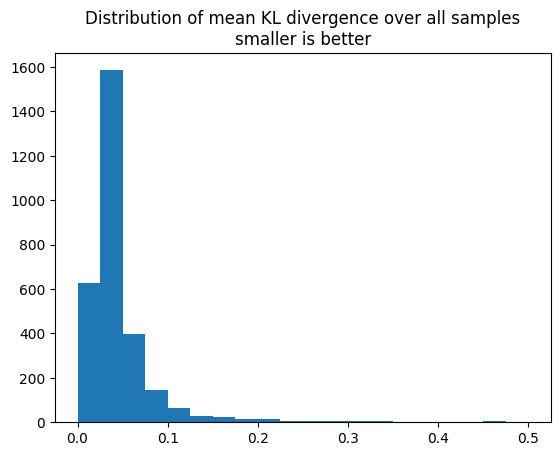

In [90]:
plt.hist([sample.metrics.get("mean_KL_divergence") for sample in detection_res.biased_samples], bins=20, range=[0,0.5])
plt.title("Distribution of mean KL divergence over all samples\nsmaller is better");

In [91]:
from bokeh.io import show, output_notebook

output_notebook()

dashboard = detection_res.dashboard()
show(dashboard)

Loading BokehJS ...

In [92]:
pos_dashboard = detection_res.dashboard(use_position=True)
show(pos_dashboard)

## Try to cluster detected biases

In [41]:
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer

In [42]:
# Prepare embeddings
docs = [sample.text for sample in detection_res.biased_samples]
y = [", ".join(sample.bias_concepts) for sample in detection_res.biased_samples]
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
vectorizer_model = CountVectorizer(stop_words="english")
embeddings = sentence_model.encode(docs, show_progress_bar=False)

hdbscan_model = HDBSCAN(min_cluster_size=5, metric='euclidean', cluster_selection_method='eom') #, max_cluster_size=25)
# Train BERTopic
topic_model = BERTopic(hdbscan_model=hdbscan_model, vectorizer_model=vectorizer_model).fit(docs, embeddings)

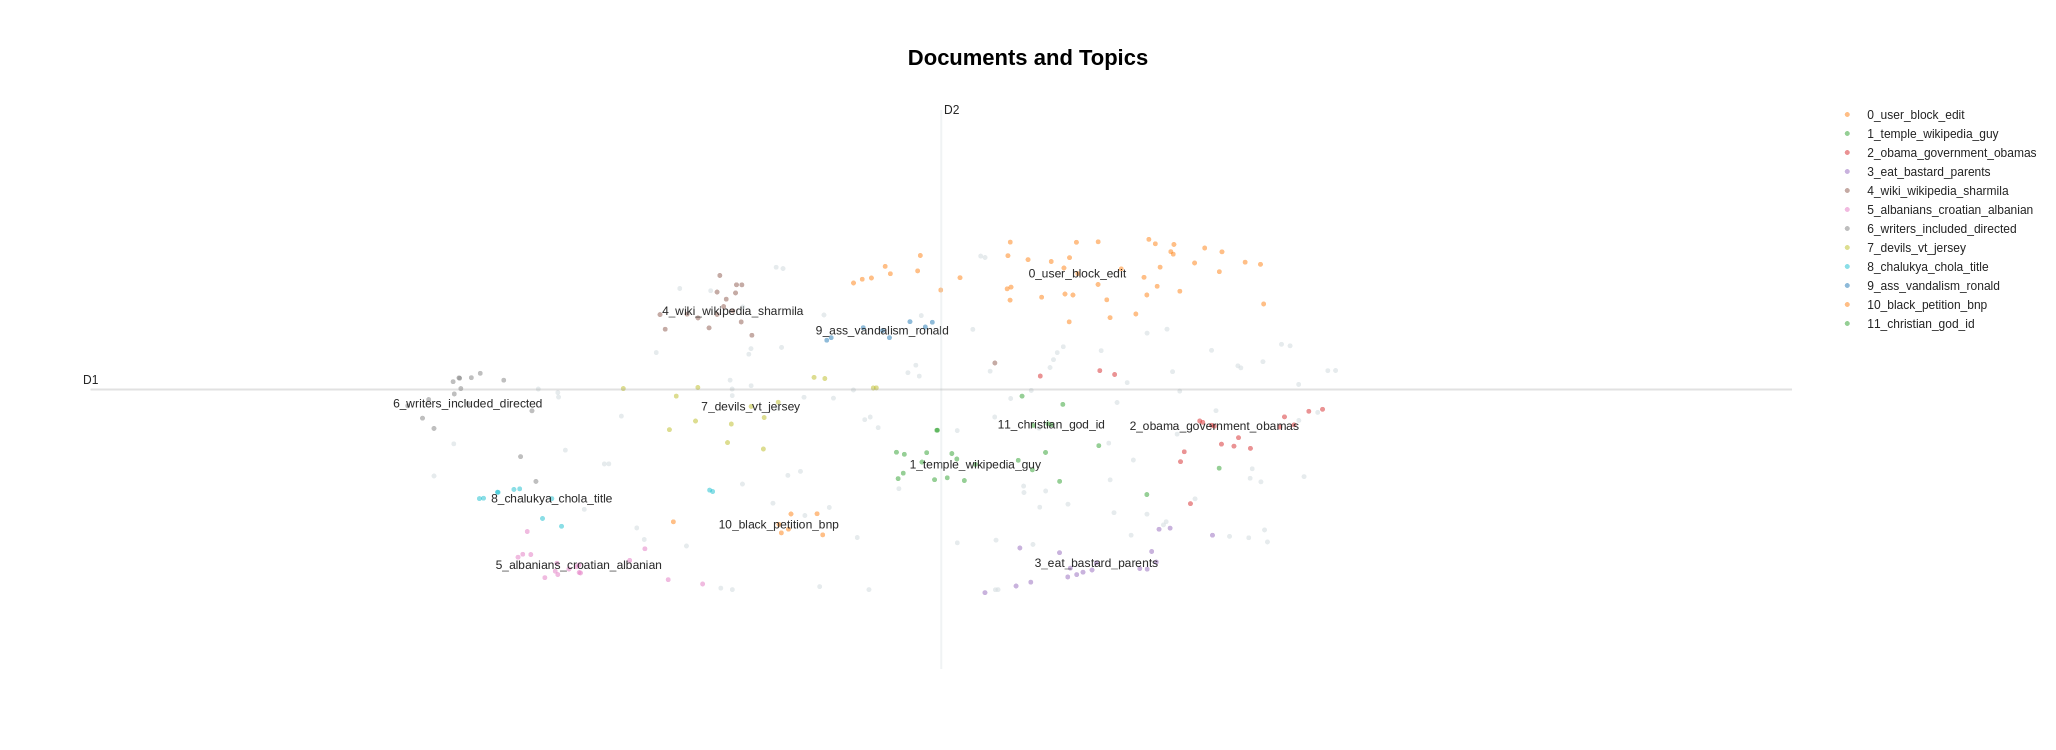

In [43]:
# Run the visualization with the original embeddings
topic_model.visualize_documents(docs, embeddings=embeddings)

# Reduce dimensionality of embeddings, this step is optional but much faster to perform iteratively:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
topic_model.visualize_documents(docs, reduced_embeddings=reduced_embeddings)

In [44]:
topic_model.topic_labels_

{-1: '-1_article_nvc_think_section',
 0: '0_user_block_edit_page',
 1: '1_temple_wikipedia_guy_just',
 2: '2_obama_government_obamas_doesnt',
 3: '3_eat_bastard_parents_wedge',
 4: '4_wiki_wikipedia_sharmila_editors',
 5: '5_albanians_croatian_albanian_serbian',
 6: '6_writers_included_directed_copyright',
 7: '7_devils_vt_jersey_new',
 8: '8_chalukya_chola_title_official',
 9: '9_ass_vandalism_ronald_gay',
 10: '10_black_petition_bnp_link',
 11: '11_christian_god_id_smiths'}

In [45]:
import yaml
from bokeh.themes import Theme
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, Slider, TextInput, HoverTool
from bokeh.palettes import Spectral5, Accent5, Category10_10, Category20_20
from bokeh.io import curdoc
from bokeh.layouts import column, row


def bkapp(doc):
    hover_tool = HoverTool(tooltips=[("Text", "@text"), ("Keywords", "@keywords")])
    p = figure(width=1200, height=800, tools=["pan","wheel_zoom","box_zoom","reset", hover_tool])

    bias_concept = [",".join(sample.bias_concepts) for sample in detection_res.biased_samples]
    concept2int = list(set(bias_concept))
    num_bias_concept = [concept2int.index(c) for c in bias_concept]
    bias_intensity = [50*np.abs(sample.score) for sample in detection_res.biased_samples]

    # configure
    df = pd.DataFrame(dict(
        text=[sample.text for sample in detection_res.biased_samples],
        keywords=[",".join(sample.bias_reasons) for sample in detection_res.biased_samples],
        x=reduced_embeddings[:,0],
        y=reduced_embeddings[:,1],
        color=[Category20_20[idx] for idx in num_bias_concept],
        bias_intensity=bias_intensity,
        bias_concept=bias_concept,
    ))
    source = ColumnDataSource(data=df)

    # add a circle renderer with a size, color, and alpha
    p.scatter(
        "x", "y",
        source=source,
        color="color",
        size="bias_intensity",
        alpha=0.3,
        legend_group="bias_concept",
    )

    p.legend.location = "top_left"
    #p.legend.click_policy="hide"

    # slider
    threshold = Slider(title="threshold", value=0.0, start=0.0, end=1.0, step=0.01, width=750)

    def update_data(attrname, old, new):
        # Get the current slider values
        t = threshold.value
        new_df = df.copy()
        new_df["bias_intensity"] = new_df.bias_intensity.apply(lambda x: x if x >= 50*t else 0.0)
        source.data = new_df

    threshold.on_change('value', update_data)


    doc.add_root(column(threshold, p, width=800))
    # show the results
    doc.theme = Theme(json=yaml.load("""
        attrs:
            figure:
                background_fill_color: "#DDDDDD"
                outline_line_color: white
                toolbar_location: above
                height: 800
                width: 1200
            Grid:
                grid_line_dash: [6, 4]
                grid_line_color: white
    """, Loader=yaml.FullLoader))

show(bkapp)

## Testing a sentiment analysis model from huggingface

In [ ]:
from transformers import pipeline
from torch.utils.data import Dataset


classifier = pipeline(
    model="distilbert-base-uncased-finetuned-sst-2-english",
    top_k=None,
    padding=True,
    truncation=True
)

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return self.data[i]


def predict_sentiment(texts):
    data = MyDataset(texts)
    proba = []
    for res in classifier(data):
        proba_array = []
        for p in sorted(res, key=lambda d: d['label'], reverse=True):
            proba_array.append(p.get("score"))
        proba.append(np.array(proba_array))
    return np.array(proba) / np.array(proba).sum(axis=1)[:,None]

In [ ]:
bias_detector = LimeKeywordBiasDetector(
    bias_evaluator=LimeBiasEvaluator(n_lime_samples=500),
    n_top_keywords=10,
    use_tokenizer=True
)

In [ ]:
test_texts = df.comment_text.sample(50)
detection_res = bias_detector.detect(texts=test_texts, predict_func=predict_sentiment)

In [ ]:
detection_res.summary()

In [ ]:
detection_res.details(group_by_concept=True)

## !! Very Experimental !!: Test masked language model based bias detection with keywords

In [ ]:
from biaslyze.bias_detectors import MaskedKeywordBiasDetector
from biaslyze.concept_detectors import KeywordConceptDetector

In [ ]:
bias_detector = MaskedKeywordBiasDetector(n_resample_keywords=20, use_tokenizer=True)

In [ ]:
detection_res = bias_detector.detect(
    texts=df.comment_text.sample(1000),
    predict_func=clf.predict_proba
)

In [ ]:
detection_res.summary()

In [ ]:
detection_res.details()

In [ ]:
from bokeh.io import show, output_notebook

output_notebook()

dashboard = detection_res.dashboard()
show(dashboard)